### Ethnicolr: NC Voter Registration Name Model

We build new LSTM models based on NC data. We start by assuming y = concatenation of ethnic code and race code. We remove U and also UN --- assuming they are 'missing at random.' This gives us 12 categories.


In [1]:
import keras
import tensorflow as tf
print(keras.__version__)
print(tf.__version__)

2021-12-21 15:33:59.210271: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-21 15:33:59.210323: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2.5.0
2.5.2


In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

In [3]:
NGRAMS = (2, 3)
SAMPLE = 1000000
EPOCHS = 15

# Florida voter
df = pd.read_csv('/opt/data/nc_voter/nc_voter_name_gender_race_ethnic_age.csv.gz', usecols=['last_name', 'first_name', 'race_code', 'ethnic_code'], nrows=SAMPLE * 2)
df.dropna(subset=['first_name', 'last_name'], inplace=True)

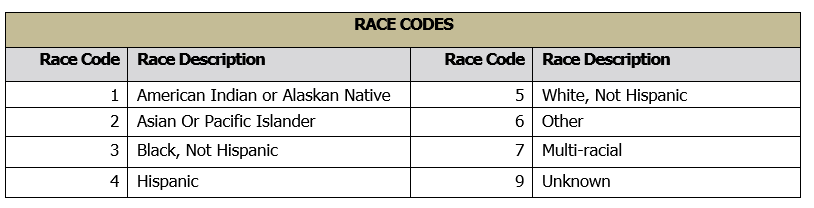

### Drop U and UN from race and ethnic.

In [4]:
df.drop(df[(df.race_code=='U')|(df.ethnic_code=='UN')].index, inplace=True)
df

,last_name,first_name,race_code,ethnic_code
0,AABEL,EVELYN,W,NL
2,AARON,CLAUDIA,W,NL
6,AARON,SANDRA,W,HL
7,AARON,WILLIE,W,NL
8,AARONSON,GENA,W,NL
...,...,...,...,...
1999993,LEAHY,YVETTE,W,NL
1999995,LEAK,ANTHONY,B,NL
1999996,LEAK,ANTOINETTE,B,NL
1999997,LEAK,BETTY,B,NL


In [5]:
df.groupby(['race_code', 'ethnic_code']).size()

race_code  ethnic_code
A          HL                 149
           NL               10142
B          HL                1497
           NL              266127
I          HL                 157
           NL                5284
M          HL                2634
           NL                5054
O          HL               18580
           NL               17627
W          HL               10598
           NL             1210076
dtype: int64

In [6]:
df['race'] = df['ethnic_code'] + '+' + df['race_code']
df

,last_name,first_name,race_code,ethnic_code,race
0,AABEL,EVELYN,W,NL,NL+W
2,AARON,CLAUDIA,W,NL,NL+W
6,AARON,SANDRA,W,HL,HL+W
7,AARON,WILLIE,W,NL,NL+W
8,AARONSON,GENA,W,NL,NL+W
...,...,...,...,...,...
1999993,LEAHY,YVETTE,W,NL,NL+W
1999995,LEAK,ANTHONY,B,NL,NL+B
1999996,LEAK,ANTOINETTE,B,NL,NL+B
1999997,LEAK,BETTY,B,NL,NL+B


In [7]:
df.drop_duplicates(inplace=True)

In [8]:
df.groupby(['race']).size()

race
HL+A       149
HL+B      1491
HL+I       156
HL+M      2606
HL+O     17325
HL+W     10281
NL+A      9682
NL+B    215904
NL+I      5048
NL+M      5016
NL+O     17326
NL+W    829509
dtype: int64

In [9]:
max_size = df['race'].value_counts().max()
lst = [df]
for class_index, group in df.groupby('race'):
    lst.append(group.sample(max_size-len(group), replace=True))
odf = pd.concat(lst)
odf

,last_name,first_name,race_code,ethnic_code,race
0,AABEL,EVELYN,W,NL,NL+W
2,AARON,CLAUDIA,W,NL,NL+W
6,AARON,SANDRA,W,HL,HL+W
7,AARON,WILLIE,W,NL,NL+W
8,AARONSON,GENA,W,NL,NL+W
...,...,...,...,...,...
1287013,QUICK,MARIA,O,NL,NL+O
1038780,NAZ,UZMA,O,NL,NL+O
1791269,VOUNN,RET,O,NL,NL+O
1581968,SIGUENZA,CAROLYN MARIE,O,NL,NL+O


In [10]:
odf.groupby('race').agg({'first_name': 'count'})

,first_name
race,
HL+A,829509
HL+B,829509
HL+I,829509
HL+M,829509
HL+O,829509
HL+W,829509
NL+A,829509
NL+B,829509
NL+I,829509


In [11]:
sdf = odf.sample(SAMPLE, random_state=21)
sdf

,last_name,first_name,race_code,ethnic_code,race
1202736,DIAZ,ALBINO,O,HL,HL+O
1659672,FERNANDEZ,JESSE,W,HL,HL+W
1444502,EVANS,DWAYNE,I,NL,NL+I
510742,MALDONADO,MEDINA,I,HL,HL+I
1464755,GROSS,SCOTT,O,NL,NL+O
...,...,...,...,...,...
1359959,RODRIGUEZ,TRISTAN,M,HL,HL+M
1593736,STOLARSKI,WANDA,W,HL,HL+W
1381683,ALLEN,CHANTEL,B,HL,HL+B
126373,LACKEY,GRIER,W,NL,NL+W


In [12]:
# Additional features
sdf['first_name'] = sdf.first_name.str.title()
sdf['last_name'] = sdf.last_name.str.title()

rdf = sdf.groupby('race').agg({'first_name': 'count'})
rdf

,first_name
race,
HL+A,83345
HL+B,83134
HL+I,83668
HL+M,83366
HL+O,83054
HL+W,82852
NL+A,83706
NL+B,83335
NL+I,83141


In [13]:
rdf.to_csv('./nc_voter_reg/lstm/nc_name_race.csv', columns=[])

## Preprocessing the input data

In [14]:
%%time
# concat last name and first name
sdf['last_name_first_name'] = sdf['last_name'] + ' ' + sdf['first_name']

# build n-gram list
vect = CountVectorizer(analyzer='char', max_df=0.3, min_df=10, ngram_range=NGRAMS, lowercase=False) 
a = vect.fit_transform(sdf.last_name_first_name)
vocab = vect.vocabulary_

# sort n-gram by freq (highest -> lowest)
words = []
for b in vocab:
    c = vocab[b]
    #print(b, c, a[:, c].sum())
    words.append((a[:, c].sum(), b))
    #break
words = sorted(words, reverse=True)
words_list = ['UNK']
words_list.extend([w[1] for w in words])
num_words = len(words_list)
print("num_words = %d" % num_words)

num_words = 11953
CPU times: user 24min 39s, sys: 316 ms, total: 24min 39s
Wall time: 24min 42s


In [15]:
vocab

{'Di': 1264,
 'ia': 6878,
 'az': 4743,
 'z ': 11729,
 ' A': 2,
 'Al': 731,
 'lb': 7740,
 'bi': 4850,
 'in': 7103,
 'no': 8615,
 'Dia': 1266,
 'iaz': 6906,
 'az ': 4744,
 'z A': 11730,
 ' Al': 15,
 'Alb': 735,
 'lbi': 7743,
 'bin': 4862,
 'ino': 7120,
 'Fe': 1606,
 'er': 5890,
 'rn': 9777,
 'na': 8376,
 'an': 4491,
 'nd': 8426,
 'de': 5303,
 'ez': 6053,
 ' J': 144,
 'Je': 2138,
 'es': 5917,
 'ss': 10218,
 'se': 10062,
 'Fer': 1616,
 'ern': 5906,
 'rna': 9780,
 'nan': 8392,
 'and': 4497,
 'nde': 8431,
 'dez': 5330,
 'ez ': 6054,
 'z J': 11739,
 ' Je': 150,
 'Jes': 2155,
 'ess': 5937,
 'sse': 10224,
 'Ev': 1561,
 'va': 11071,
 'ns': 8661,
 's ': 9962,
 ' D': 52,
 'Dw': 1355,
 'wa': 11216,
 'ay': 4714,
 'yn': 11623,
 'ne': 8451,
 'Eva': 1562,
 'van': 11086,
 'ans': 4512,
 'ns ': 8662,
 's D': 9966,
 ' Dw': 63,
 'Dwa': 1356,
 'way': 11235,
 'ayn': 4730,
 'yne': 11628,
 'Ma': 2556,
 'al': 4439,
 'ld': 7760,
 'do': 5415,
 'on': 9042,
 'ad': 4271,
 'o ': 8764,
 ' M': 181,
 'Me': 2606,
 'ed': 5

In [16]:
from itertools import chain

def n_grams(seq, n=1):
    """Returns an itirator over the n-grams given a listTokens"""
    shiftToken = lambda i: (el for j,el in enumerate(seq) if j>=i)
    shiftedTokens = (shiftToken(i) for i in range(n))
    tupleNGrams = zip(*shiftedTokens)
    return tupleNGrams # if join in generator : (" ".join(i) for i in tupleNGrams)

def range_ngrams(listTokens, ngramRange=(1,2)):
    """Returns an itirator over all n-grams for n in range(ngramRange) given a listTokens."""
    ngrams = (ngramRange[0], ngramRange[1] + 1)
    return chain(*(n_grams(listTokens, i) for i in range(*ngramRange)))

In [17]:
%%time
def find_ngrams(text, ngrams):
    a = range_ngrams(text, ngrams)
    wi = []
    for i in a:
        w = ''.join(i)
        try:
            idx = words_list.index(w)
        except:
            idx = 0
        wi.append(idx)
    return wi

# build X from index of n-gram sequence
X = np.array(sdf.last_name_first_name.apply(lambda c: find_ngrams(c, NGRAMS)))

# check max/avg feature
X_len = []
for x in X:
    X_len.append(len(x))

max_feature_len = max(X_len)
avg_feature_len = int(np.mean(X_len))

print("Max feature len = %d, Avg. feature len = %d" % (max_feature_len, avg_feature_len))
y = np.array(sdf.race.astype('category').cat.codes)

# Split train and test dataset
X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)

Max feature len = 37, Avg. feature len = 12
CPU times: user 1min 33s, sys: 396 ms, total: 1min 33s
Wall time: 1min 33s


## Train a LSTM model

ref: http://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/

In [18]:
'''The dataset is actually too small for LSTM to be of any advantage
compared to simpler, much faster methods such as TF-IDF + LogReg.
Notes:

- RNNs are tricky. Choice of batch size is important,
choice of loss and optimizer is critical, etc.
Some configurations won't converge.

- LSTM loss decrease patterns during training can be quite different
from what you see with CNNs/MLPs/etc.
'''
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, Activation
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.models import load_model

max_features = num_words # 20000
feature_len = 25 # avg_feature_len # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

print('Pad sequences (samples x time)')
X_train = sequence.pad_sequences(X_train, maxlen=feature_len)
X_test = sequence.pad_sequences(X_test, maxlen=feature_len)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

num_classes = np.max(y_train) + 1
print(num_classes, 'classes')

print('Convert class vector to binary class matrix '
      '(for use with categorical_crossentropy)')
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

800000 train sequences
200000 test sequences
Pad sequences (samples x time)
X_train shape: (800000, 25)
X_test shape: (200000, 25)
12 classes
Convert class vector to binary class matrix (for use with categorical_crossentropy)
y_train shape: (800000, 12)
y_test shape: (200000, 12)


In [19]:
print('Build model...')

if False:
    model = Sequential()
    model.add(Embedding(num_words, 32, input_length=feature_len))
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(num_classes, activation='softmax'))
if True:
    embedding_vecor_length = 50
    model = Sequential()
    model.add(Embedding(num_words, embedding_vecor_length, input_length=feature_len))
    model.add(Conv1D(activation="relu", padding="same", filters=32, kernel_size=3))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(100))
    model.add(Dense(num_classes, activation='softmax'))

# try using different optimizers and different optimizer configs
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

Build model...


2021-12-21 16:00:40.470862: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-21 16:00:40.470906: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-21 16:00:40.470926: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-server-2): /proc/driver/nvidia/version does not exist
2021-12-21 16:00:40.471412: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 50)            597650    
_________________________________________________________________
conv1d (Conv1D)              (None, 25, 32)            4832      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 12, 32)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               53200     
_________________________________________________________________
dense (Dense)                (None, 12)                1212      
Total params: 656,894
Trainable params: 656,894
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
%%time
print('Train...')
model.fit(X_train, y_train, batch_size=batch_size, epochs=EPOCHS,
          validation_split=0.1, verbose=1)
score, acc = model.evaluate(X_test, y_test,
                            batch_size=batch_size, verbose=1)
print('Test score:', score)
print('Test accuracy:', acc)

Train...


2021-12-21 16:00:41.263387: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-21 16:00:41.264190: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2250000000 Hz


Epoch 1/15
22500/22500 [==============================] - 379s 16ms/step - loss: 1.6927 - accuracy: 0.3797 - val_loss: 1.2747 - val_accuracy: 0.5254
Epoch 2/15
22500/22500 [==============================] - 352s 16ms/step - loss: 1.1901 - accuracy: 0.5637 - val_loss: 1.0297 - val_accuracy: 0.6198
Epoch 3/15
22500/22500 [==============================] - 353s 16ms/step - loss: 0.9671 - accuracy: 0.6447 - val_loss: 0.8992 - val_accuracy: 0.6678
Epoch 4/15
22500/22500 [==============================] - 345s 15ms/step - loss: 0.8556 - accuracy: 0.6838 - val_loss: 0.8434 - val_accuracy: 0.6901
Epoch 5/15
22500/22500 [==============================] - 320s 14ms/step - loss: 0.7969 - accuracy: 0.7063 - val_loss: 0.8189 - val_accuracy: 0.6994
Epoch 6/15
22500/22500 [==============================] - 360s 16ms/step - loss: 0.7642 - accuracy: 0.7177 - val_loss: 0.7994 - val_accuracy: 0.7060
Epoch 7/15
22500/22500 [==============================] - 391s 17ms/step - loss: 0.7423 - accuracy: 0.7253

In [21]:
print('Test score:', score)
print('Test accuracy:', acc)

Test score: 0.7481632828712463
Test accuracy: 0.7271400094032288


## Confusion Matrix

In [22]:
p = model.predict(X_test, verbose=2) # to predict probability
y_pred = np.argmax(p, axis=-1)
target_names = list(sdf.race.astype('category').cat.categories)
print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names))

conf_mat = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
print(conf_mat)

6250/6250 - 32s
              precision    recall  f1-score   support

        HL+A       0.99      1.00      1.00     16669
        HL+B       0.92      0.98      0.95     16627
        HL+I       0.99      1.00      0.99     16734
        HL+M       0.89      0.92      0.90     16673
        HL+O       0.54      0.59      0.56     16611
        HL+W       0.55      0.53      0.54     16570
        NL+A       0.76      0.80      0.78     16741
        NL+B       0.49      0.41      0.45     16667
        NL+I       0.76      0.91      0.83     16628
        NL+M       0.79      0.88      0.83     16738
        NL+O       0.50      0.29      0.37     16632
        NL+W       0.40      0.43      0.41     16710

    accuracy                           0.73    200000
   macro avg       0.72      0.73      0.72    200000
weighted avg       0.72      0.73      0.72    200000

[[16669     0     0     0     0     0     0     0     0     0     0     0]
 [    0 16270     0   102    45    26     

In [27]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

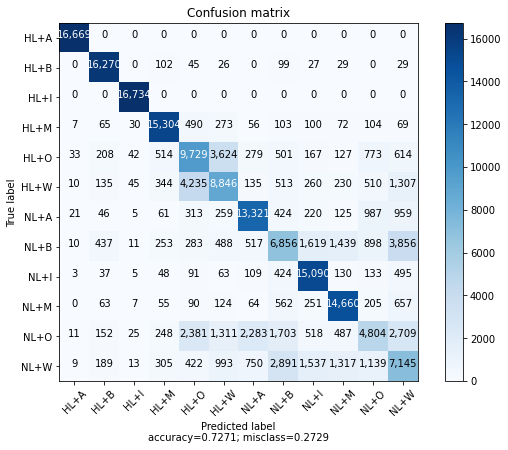

In [28]:
plot_confusion_matrix(conf_mat, target_names, normalize=False)

### Save model

In [29]:
model.save('./nc_voter_reg/lstm/nc_voter_name_lstm_oversample.h5')

In [30]:
words_df = pd.DataFrame(words_list, columns=['vocab'])
words_df.to_csv('./nc_voter_reg/lstm/nc_voter_name_vocab_oversample.csv', index=False, encoding='utf-8')